<a href="https://colab.research.google.com/github/janphiliprichter/PradoImageClassification/blob/main/AMD_Project_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing and Importing Dependencies

In [ ]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 13.8 MB/s eta 0:00:00


In [ ]:
import os
import requests
from multiprocessing import cpu_count
from multiprocessing.pool import ThreadPool
import visualkeras as vk
import pandas as pd
import numpy as np
from scipy.optimize import fsolve
from math import exp
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import tensorflow as tf
import keras.backend as K
from keras.layers import Layer
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, \
    AveragePooling2D, BatchNormalization, ReLU, PReLU, ZeroPadding2D, \
    GlobalAveragePooling2D, Input, DepthwiseConv2D, Add, Activation, Lambda, RandomFlip
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_v2_preproccessing
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_preproccessing
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B3
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg_preproccessing
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocessing

# Helper Functions, Directories and Settings

## Downloading URLs

In [ ]:
def download_url(args):
    """
    Downloads a file from an url
    :param args: Tuple containing the url and filename
    :return: None
    """
    url, filename = args[0], args[1]
    try:
      r = requests.get(url)
      if r.status_code != 404:
        with open(filename, "wb") as f:
          f.write(r.content)

    except Exception as e:
      print("Exception in download_url():", e)

In [ ]:
def download_parallel(args):
    """
    Downloads urls in parallel
    :param args: List of tuples containing the url and filename
    :return: None
    """
    cpus = cpu_count()
    threadpool = ThreadPool(cpus)
    results = threadpool.imap_unordered(download_url, args)
    threadpool.close()
    threadpool.join()

## PCA Data Augmentation

PCA Data Augmentation as by Krizhevsky

Code obtained from: https://github.com/koshian2/PCAColorAugmentation/tree/master

In [ ]:
class PCAColorAugmentationGPU(Layer):
    """
    PCA colour augmentation layer to be used in a tensorflow model
    """
    def __init__(self, std_deviation=0.1, clipping=False, scale=1.0, **kwargs):
        super().__init__(**kwargs)
        self.std_deviation = std_deviation
        self.clipping = clipping
        self.scale = scale

    def build(self, input_shape):
        return super().build(input_shape)

    def augmentation(self, inputs):
        # assume channels-last
        input_shape = K.int_shape(inputs)
        ranks = len(input_shape)
        assert ranks >= 2 and ranks <=5
        chs = input_shape[-1]

        # swapaxis, reshape for calculating covariance matrix
        # rank 2 = (batch, dims)
        # rank 3 = (batch, step, dims)
        if ranks <= 3:
            x = inputs
        # rank 4 = (batch, height, width, ch) -> (batch, dims, ch)
        elif ranks == 4:
            dims = input_shape[1] * input_shape[2]
            x = tf.reshape(inputs, (-1, dims, chs))
        # rank 5 = (batch, D, H, W, ch) -> (batch, D, dims, ch)
        elif ranks == 5:
            dims = input_shape[2] * input_shape[3]
            depth = input_shape[1]
            x = tf.reshape(inputs, (-1, depth, dims, chs))

        # scaling-factor
        calculate_axis, reduce_axis = ranks-1, ranks-2
        if ranks == 3:
            calculate_axis, reduce_axis = 1, 2
        elif ranks >= 4:
            calculate_axis, reduce_axis = ranks-3, ranks-2
        C = 1.0
        if ranks >= 3:
            C = K.int_shape(x)[reduce_axis]
        var = K.var(x, axis=calculate_axis, keepdims=True)
        scaling_factors = tf.sqrt(C / tf.reduce_sum(var, axis=reduce_axis, keepdims=True))
        # scaling
        x = x * scaling_factors

        # subtract mean for cov matrix
        mean = tf.reduce_mean(x, axis=calculate_axis, keepdims=True)
        x -= mean

        # covariance matrix
        cov_n = max(K.int_shape(x)[calculate_axis] - 1, 1)
        # cov (since x was normalized)
        cov = tf.matmul(x, x, transpose_a=True) / cov_n

        # eigen value(S), eigen vector(U)
        S, U, V = tf.linalg.svd(cov)
        # eigen_values vs eigen_vectors
        # rank = 2 : (dims) vs (dims, dims)
        # rank = 3 : (batch, dims) vs (batch, dims, dims)
        # rank = 4 : (batch, ch) vs (batch, ch, ch)
        # rank = 5 : (batch, D, ch) vs (batch, D, ch, ch)

        # random values
        # if rank2 : get differnt random variable by sample
        if ranks == 2:
            rand = tf.random.normal(tf.shape(inputs), mean=0.0, stddev=self.std_deviation)
            delta = tf.matmul(rand*tf.expand_dims(S, axis=0), U)
        else:
            rand = tf.random.normal(tf.shape(S), mean=0.0, stddev=self.std_deviation)
            delta_original = tf.squeeze(tf.matmul(U, tf.expand_dims(rand*S, axis=-1)), axis=-1)

        # adjust delta shape
        # rank = 3 : (batch, dims) -> (batch, 1[step], dims)
        # rank = 4 : (batch, ch) -> (batch, 1[ndim], ch)
        # rank = 5 : (batch, D, ch) -> (batch, D, 1[ndim], ch)
        if ranks == 3:
            delta = tf.expand_dims(delta_original, axis=ranks-2)
        elif ranks >= 4:
            delta = K.expand_dims(delta_original, axis=ranks-3)
            # reshape to original input shape(if rank >= 4)
            # rank = 4 : (batch, ndim, ch) -> (batch, height, width, ch)
            # rank = 5 : (batch, D, ndim, ch) -> (batch, D, height, width, ch)
            delta = tf.broadcast_to(delta, tf.shape(x))
            delta = K.reshape(delta, [-1, *input_shape[1:]])

        # delta scaling
        delta = delta * self.scale

        #print("scaling factor", K.int_shape(scaling_factors))
        #print("mean", K.int_shape(mean))
        #print("cov", K.int_shape(cov))
        #print("S", K.int_shape(S))
        #print("U", K.int_shape(U))
        #print("rand", K.int_shape(rand))
        #print("delta_original", K.int_shape(delta_original))
        #print("delta", K.int_shape(delta))

        # clipping (if clipping=True)
        result = inputs + delta
        if self.clipping:
            result = tf.clip_by_value(result, 0.0, self.scale)

        return result

    def call(self, inputs):
        return K.in_train_phase(self.augmentation(inputs), inputs)

    def compute_output_shape(self, input_shape):
        return input_shape

## Resiudal Blocks

Code inspired by:
https://github.com/AarohiSingla/ResNet50/blob/master/3-resnet50_rooms_dataset.ipynb


In [ ]:
def three_layer_identity_block(tensor, num_filters, stage):
    """
    Creates a three-layer identity block for a ResNet model.
    :param tensor: input tensor for the block
    :param num_filters: Int. Number of filters for the convolutional layers
    :param stage: Int. Counter for numbering the identity blocks
    :return: output tensor
    """

    # Saving the unaltered tensor to add to the convolutional output later
    shortcut_tensor = tensor

    # 1st convolutional block
    tensor = Conv2D(filters=num_filters,
                    kernel_size=(1, 1),
                    strides=(1, 1),
                    padding="valid",
                    kernel_initializer="HeNormal",
                    name=f"Conv1_{stage}")(tensor)

    tensor = BatchNormalization(axis=3,
                                name=f"BatchNorm1_{stage}")(tensor)

    tensor = ReLU(name=f"ReLU1_{stage}")(tensor)

    # 2nd convolutional block
    tensor = Conv2D(filters=num_filters,
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    padding="same",
                    kernel_initializer="HeNormal",
                    name=f"Conv2_{stage}")(tensor)  # Padding to keep dimensions

    tensor = BatchNormalization(axis=3,
                                name=f"BatchNorm2_{stage}")(tensor)

    tensor = ReLU(name=f"ReLU2_{stage}")(tensor)

    # 3rd convolutional block
    tensor = Conv2D(filters=num_filters * 4,
                    kernel_size=(1, 1),
                    strides=(1, 1),
                    padding="valid",
                    kernel_initializer="HeNormal",
                    name=f"Conv3_{stage}")(tensor)

    tensor = BatchNormalization(axis=3,
                                name=f"BatchNorm3_{stage}")(tensor)

    tensor = ReLU(name=f"ReLU3_{stage}")(tensor)

    # Skip connection
    tensor = Add(name=f"SkipConnection_{stage}")([tensor, shortcut_tensor])
    tensor = ReLU(name=f"ReLU4_{stage}")(tensor)

    return tensor



def three_layer_projection_block(tensor, num_filters, stage, strides=(2, 2)):
    """
    Creates a three-layer projection block for a ResNet model.
    :param tensor: input tensor for the block
    :param num_filters: Int. Number of filters for the convolutional layers
    :param stage: Int. Counter for numbering the identity blocks
    :param strides: Tuple of the strides
    :return: output tensor
    """

    # Saving the unaltered tensor to add to the convolutional output later
    shortcut_tensor = tensor

    # 1st convolutional block
    tensor = Conv2D(filters=num_filters,
                    kernel_size=(1, 1),
                    strides=strides,  # Strides are (2, 2) to reduce the dimensions
                    kernel_initializer="HeNormal",
                    padding="valid",
                    name=f"Conv1_{stage}")(tensor)

    tensor = BatchNormalization(axis=3,
                                name=f"BatchNorm1_{stage}")(tensor)

    tensor = ReLU(name=f"ReLU1_{stage}")(tensor)

    # 2nd convolutional block
    tensor = Conv2D(filters=num_filters,
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    kernel_initializer="HeNormal",
                    padding="same",  # Padding to keep dimensions
                    name=f"Conv2_{stage}")(tensor)

    tensor = BatchNormalization(axis=3,
                                name=f"BatchNorm2_{stage}")(tensor)

    tensor = ReLU(name=f"ReLU2_{stage}")(tensor)

    # 3rd convolutional block
    tensor = Conv2D(filters=num_filters * 4,
                    kernel_size=(1, 1),
                    strides=(1, 1),
                    kernel_initializer="HeNormal",
                    padding="valid",
                    name=f"Conv3_{stage}")(tensor)

    tensor = BatchNormalization(axis=3,
                                name=f"BatchNorm3_{stage}")(tensor)

    tensor = ReLU(name=f"ReLU3_{stage}")(tensor)

    # 1x1 convolution for the shortcut tensor
    shortcut_tensor = Conv2D(filters=num_filters * 4,
                             kernel_size=(1, 1),
                             strides=strides,  # Strides are (2, 2) to reduce the dimensions
                             padding="valid",
                             kernel_initializer="HeNormal",
                             name=f"Conv4_{stage}")(shortcut_tensor)

    shortcut_tensor = BatchNormalization(axis=3,
                                         name=f"BatchNorm4_{stage}")(shortcut_tensor)

    # Skip connection
    tensor = Add(name=f"SkipConnection_{stage}")([tensor, shortcut_tensor])
    tensor = ReLU(name=f"ReLU4_{stage}")(tensor)

    return tensor

## Bottleneck Blocks

In [ ]:
def bottleneck_block(tensor, num_filters, stage, expansion=6, strides=(1, 1)):
    """
    Creates a three-layer linear bottleneck block for a MobileNet model.
    :param tensor: input tensor for the block
    :param num_filters: Int. Number of filters for the convolutional layers
    :param stage: Int. Counter for numbering the identity blocks
    :param expansion: Int. expansion factor for number of filters
    :param strides: Tuple for the strides in the first layer of the block
    :return: output tensor
    """

    # Saving the unaltered tensor to add to the convolutional output later
    shortcut_tensor = tensor

    # 1st convolutional block
    tensor = Conv2D(filters=num_filters*expansion,
                    kernel_size=(1, 1),
                    strides=strides,
                    padding="valid",
                    kernel_initializer="HeNormal",
                    name=f"Conv1_{stage}")(tensor)

    tensor = BatchNormalization(axis=3,
                                name=f"BatchNorm1_{stage}")(tensor)

    tensor = Activation(activation="relu6",
                        name=f"ReLU1_{stage}")(tensor)

    # 2nd convolutional block
    tensor = DepthwiseConv2D(
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    padding="same",
                    kernel_initializer="HeNormal",
                    name=f"Conv2_{stage}")(tensor)

    tensor = BatchNormalization(axis=3,
                                name=f"BatchNorm2_{stage}")(tensor)

    tensor = Activation(activation="relu6",
                        name=f"ReLU2_{stage}")(tensor)

    # 3rd convolutional block
    tensor = Conv2D(filters=num_filters,
                    kernel_size=(1, 1),
                    strides=(1, 1),
                    padding="valid",
                    kernel_initializer="HeNormal",
                    name=f"Conv3_{stage}")(tensor)

    tensor = BatchNormalization(axis=3,
                                name=f"BatchNorm3_{stage}")(tensor)


    if strides == (1, 1):
      # Skip connection

      if shortcut_tensor.shape != tensor.shape:
        shortcut_tensor = Conv2D(filters=num_filters,
                      kernel_size=(1, 1),
                      strides=strides,
                      padding="valid",
                      kernel_initializer="HeNormal",
                      name=f"Conv_Dim_{stage}")(shortcut_tensor)


      tensor = Add(name=f"SkipConnection_{stage}")([tensor, shortcut_tensor])

    return tensor

## Learning Rate Scheduler

In [ ]:
def scheduler(epoch, lr):
    """
    Creates schedule to obtain an exponential decay of the learning rate
    :param epoch: Int. Epoch at which we start the decay of the learning rate
    :param lr: Float Learning rate for the optimiser
    :return: Learning rate for a given epoch
    """
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.05)

## Class Weigths and Output Biases

Code obtained from:
https://stackoverflow.com/questions/60307239/setting-bias-for-multiclass-classification-python-tensorflow-keras

In [ ]:
class_obs = np.array([1080, 446, 326, 290, 222])
class_frequencies = class_obs / sum(class_obs)

class_weights = {}
for cls, freq in enumerate(class_obs):
  class_weights[cls] = (1 / class_obs[cls]) * sum(class_obs) / len(class_obs)


def eqn(x, frequency=class_frequencies):
      sum_exp = sum([exp(x_i) for x_i in x])
      return [exp(x[i])/sum_exp - frequency[i] for i in range(len(frequency))]

  # calculate init bias
output_bias = fsolve(func=eqn,
                      x0=[0]*len(class_frequencies),).tolist()

output_bias = tf.keras.initializers.Constant(output_bias)

## Directory for logs

In [ ]:
!mkdir model_results
!mkdir transfer

## Setting Input Shape

In [ ]:
INPUT_SHAPE = (224, 224, 3)

## Plotting functions

### Visualisation settings

In [ ]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)

### Plotting function

In [ ]:
def plot_history(history, figsize=(12,6), y_lim_left=(0,1), y_lim_right=(0,1.02)):
    """
    Plots the loss and accuracy curves.
    :param df: the data frame containing the histories we want to plot
    :param y_lim: Tuple. If not differently specified, it's (0,1). Only applies to the accuracy plot.
    :return: None
    """
    fig, ax = plt.subplots(figsize=figsize, nrows=1, ncols=2)


    # Plot Loss
    sns.lineplot(data=history,
                 x="epoch",
                 y="val_loss",
                 ax=ax[0],
                 label="Validation Loss",
                 linewidth=2,
                 color="#25bdf0")

    sns.lineplot(data=history,
                 x="epoch",
                 y="loss",
                 ax=ax[0],
                 label="Training Loss",
                 linewidth=2,
                 color="#78ba41")

    # Plot Accuracy
    sns.lineplot(data=history,
                 x="epoch",
                 y="val_accuracy",
                 ax=ax[1],
                 label="Validation Accuracy",
                 linewidth=2,
                 color="#25bdf0")

    sns.lineplot(data=history,
                 x="epoch",
                 y="accuracy",
                 ax=ax[1],
                 label="Training Accuracy",
                 linewidth=2,
                 color="#78ba41")

    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Categorical Crossentropy")
    ax[0].set_title("Training Loss vs Validation Loss")
    ax[0].set_ylim(y_lim_left)
    ax[0].legend()

    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy (%)")
    ax[1].set_title("Training Accuracy vs Validation Accuracy")
    ax[1].set_ylim(y_lim_right)
    ax[1].legend(loc="lower right")

    plt.show()

# Loading the Data

## Loading prado.csv using the Kaggle API

In [ ]:
os.environ["KAGGLE_USERNAME"] = "xxxxxx"
os.environ["KAGGLE_KEY"] = "xxxxxx"
!kaggle datasets download maparla/prado-museum-pictures -f prado.csv
!unzip prado.csv.zip

 87% 16.0M/18.3M [00:00<00:00, 26.8MB/s]
100% 18.3M/18.3M [00:01<00:00, 18.2MB/s]
Archive:  prado.csv.zip
  inflating: prado.csv               


## Creating list with URLs to load

Creating the data frame containing the URLs

In [ ]:
df = pd.read_csv(os.path.join("prado.csv"))
df["work_id"] = df["work_image_url"].apply(lambda x: x.split("/")[-1])

5 painters considered for the analysis

In [ ]:
painters = ["Goya y Lucientes, Francisco de",
            "Bayeu y Subías, Francisco",
            "Haes, Carlos de",
            "Pizarro y Librado, Cecilio",
            "Ribera y Fieve, Carlos Luis de"]

painter_dirs = ["goya", "bayeu", "haes", "pizzaro", "ribera"]

Creating directories to store the data

In [ ]:
!mkdir data

for dir in painter_dirs:
  !mkdir -p data/$dir

List of URLs

In [ ]:
download_list = list()

for painter, dir in zip(painters, painter_dirs):

  painter_urls = list(df["work_image_url"].loc[df["author"] == painter])
  painter_fns = list(df["work_id"].loc[df["author"] == painter])
  painter_fns = [f"data/{dir}/" + fn for fn in painter_fns]

  for url, fn in zip(painter_urls, painter_fns):
    download_list.append((url, fn))

Parallel downloading

In [ ]:
download_parallel(download_list)

Training and testing data

In [ ]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory("/content/data",
                                                               label_mode="int",
                                                               color_mode="rgb",
                                                               batch_size=32,
                                                               image_size=(224, 224),
                                                               shuffle=True,
                                                               seed=42,
                                                               validation_split=0.2,
                                                               subset="both",
                                                               labels="inferred",
                                                               class_names=["goya", "bayeu", "haes", "pizzaro", "ribera"])

Found 2360 files belonging to 5 classes.
Using 1888 files for training.
Using 472 files for validation.


# Models

## VGG

### Model Creation

In [ ]:
vgg = Sequential([
    # Preprocessing layers
    tf.keras.layers.RandomFlip(mode="horizontal",
                               input_shape=INPUT_SHAPE,
                               name="Random_horizontal_flip"),
    tf.keras.layers.Lambda(function=tf.image.per_image_standardization,
                           name="Per_image_standardisation"),
    PCAColorAugmentationGPU(name="PCA_Colour_Augmentation"),


    # 1st convolutional block
    Conv2D(filters=64,
           kernel_size=(3, 3),
           strides=(1, 1),
           padding="same",
           activation=None,
           kernel_initializer="HeNormal",
           name="Conv_1_1"),
    BatchNormalization(name="BatchNorm_1_1"),
    ReLU(name="ReLU_1_1"),

    Conv2D(filters=64,
           kernel_size=(3, 3),
           strides=(1, 1),
           padding="same",
           activation=None,
           kernel_initializer="HeNormal",
           name="Conv_1_2"),
    BatchNormalization(name="BatchNorm_1_2"),
    ReLU(name="ReLU_1_2"),


    AveragePooling2D(pool_size=(2, 2),
                     strides=None,
                     padding="valid",
                     name="AvgPool_1"),


    # 2nd convolutional block
    Conv2D(filters=128,
           kernel_size=(3, 3),
           strides=(1, 1),
           padding="same",
           activation=None,
           kernel_initializer="HeNormal",
           name="Conv_2_1"),
    BatchNormalization(name="BatchNorm_2_1"),
    ReLU(name="ReLU_2_1"),

    Conv2D(filters=128,
           kernel_size=(3, 3),
           strides=(1, 1),
           padding="same",
           activation=None,
           kernel_initializer="HeNormal",
           name="Conv_2_2"),
    BatchNormalization(name="BatchNorm_2_2"),
    ReLU(name="ReLU_2_2"),

    AveragePooling2D(pool_size=(2, 2),
                     strides=None,
                     padding="valid",
                     name="AvgPool_2"),


    # 3rd convolutional block
    Conv2D(filters=256,
           kernel_size=(3, 3),
           strides=(1, 1),
           padding="same",
           activation=None,
           kernel_initializer="HeNormal",
           name="Conv_3_1"),
    BatchNormalization(name="BatchNorm_3_1"),
    ReLU(name="ReLU_3_1"),

    Conv2D(filters=256,
           kernel_size=(3, 3),
           strides=(1, 1),
           padding="same",
           activation=None,
           kernel_initializer="HeNormal",
           name="Conv_3_2"),
    BatchNormalization(name="BatchNorm_3_2"),
    ReLU(name="ReLU_3_2"),


    Conv2D(filters=256,
           kernel_size=(1, 1),
           strides=(1, 1),
           padding="valid",
           activation=None,
           kernel_initializer="HeNormal",
           name="Conv_3_3"),
    BatchNormalization(name="BatchNorm_3_3"),
    ReLU(name="ReLU_3_3"),



    AveragePooling2D(pool_size=(2, 2),
                     strides=None,
                     padding="valid",
                     name="AvgPool_3"),


    # 4th convolutional block
    Conv2D(filters=512,
           kernel_size=(3, 3),
           strides=(1, 1),
           padding="same",
           activation=None,
           kernel_initializer="HeNormal",
           name="Conv_4_1"),
    BatchNormalization(name="BatchNorm_4_1"),
    ReLU(name="ReLU_4_1"),

    Conv2D(filters=512,
           kernel_size=(3, 3),
           strides=(1, 1),
           padding="same",
           activation=None,
           kernel_initializer="HeNormal",
           name="Conv_4_2"),
    BatchNormalization(name="BatchNorm_4_2"),
    ReLU(name="ReLU_4_2"),


    Conv2D(filters=512,
           kernel_size=(1, 1),
           strides=(1, 1),
           padding="valid",
           activation=None,
           kernel_initializer="HeNormal",
           name="Conv_4_3"),
    BatchNormalization(name="BatchNorm_4_3"),
    ReLU(name="ReLU_4_3"),


    AveragePooling2D(pool_size=(2, 2),
                     strides=None,
                     padding="valid",
                     name="AvgPool_4"),


    Flatten(name="Flatten"),

    Dense(units=16,
          activation=None,
          kernel_initializer="HeNormal",
          bias_initializer="zeros",
          name="Dense_1"),
    BatchNormalization(name="BatchNorm_1"),
    PReLU(name="PReLU_1"),

    Dense(units=8,
          activation=None,
          kernel_initializer="HeNormal",
          bias_initializer="zeros",
          name="Dense_2"),
    BatchNormalization(name="BatchNorm_2"),
    PReLU(name="PReLU_2"),


    Dense(units=5,
          activation="softmax",
          kernel_initializer="HeNormal",
          bias_initializer=output_bias,
          name="Output")
],
    name="VGG")

In [ ]:
vgg.summary()

Model: "VGG"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Random_horizontal_flip (Ra  (None, 224, 224, 3)       0         
 ndomFlip)                                                       
                                                                 
 Per_image_standardisation   (None, 224, 224, 3)       0         
 (Lambda)                                                        
                                                                 
 PCA_Colour_Augmentation (P  (None, 224, 224, 3)       0         
 CAColorAugmentationGPU)                                         
                                                                 
 Conv_1_1 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 BatchNorm_1_1 (BatchNormal  (None, 224, 224, 64)      256       
 ization)                                                      

### Model Compiling

In [ ]:
vgg.compile(loss=SparseCategoricalCrossentropy(),
            optimizer=Adam(),
            metrics=["accuracy"])

### Model Training


#### Callbacks

In [ ]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
vgg_csv_logger = CSVLogger("/content/model_results/vgg.log")

#### Training

In [ ]:
vgg_history = vgg.fit(train_ds,
                      epochs=50,
                      steps_per_epoch=len(train_ds),
                      validation_data=val_ds,
                      validation_steps=len(val_ds),
                      class_weight=class_weights,
                      callbacks=[lr_scheduler, vgg_csv_logger])

Epoch 1/50
59/59 [==============================] - 36s 260ms/step - loss: 1.3643 - accuracy: 0.6229 - val_loss: 15.8550 - val_accuracy: 0.1801 - lr: 0.0010
Epoch 2/50
59/59 [==============================] - 17s 250ms/step - loss: 0.9240 - accuracy: 0.7722 - val_loss: 1.3074 - val_accuracy: 0.5381 - lr: 0.0010
Epoch 3/50
59/59 [==============================] - 16s 247ms/step - loss: 0.7903 - accuracy: 0.7940 - val_loss: 1.0098 - val_accuracy: 0.6377 - lr: 0.0010
Epoch 4/50
59/59 [==============================] - 16s 252ms/step - loss: 0.6257 - accuracy: 0.8353 - val_loss: 0.7939 - val_accuracy: 0.7225 - lr: 0.0010
Epoch 5/50
59/59 [==============================] - 16s 249ms/step - loss: 0.5015 - accuracy: 0.8528 - val_loss: 0.8233 - val_accuracy: 0.6547 - lr: 0.0010
Epoch 6/50
59/59 [==============================] - 17s 253ms/step - loss: 0.4273 - accuracy: 0.8745 - val_loss: 0.6988 - val_accuracy: 0.8030 - lr: 0.0010
Epoch 7/50
59/59 [==============================] - 16s 245ms/s

### Visualisations

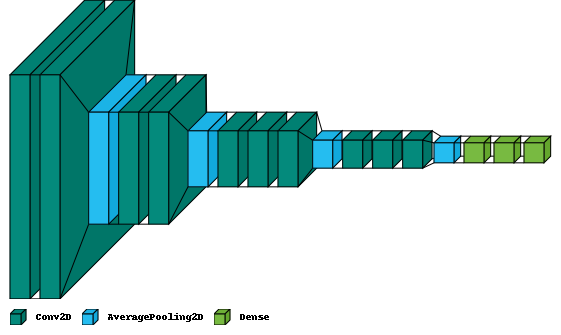

In [ ]:
color_map = defaultdict(dict)
color_map[Conv2D]["fill"] = "#048a7c"
color_map[AveragePooling2D]["fill"] = "#25bdf0"
color_map[Dense]["fill"] = "#78ba41"

vk.layered_view(vgg,
                legend=True,
                scale_xy=1,
                scale_z=.01,
                type_ignore=[PCAColorAugmentationGPU, Lambda, RandomFlip,
                             Flatten, BatchNormalization, ReLU, PReLU],
                color_map=color_map)

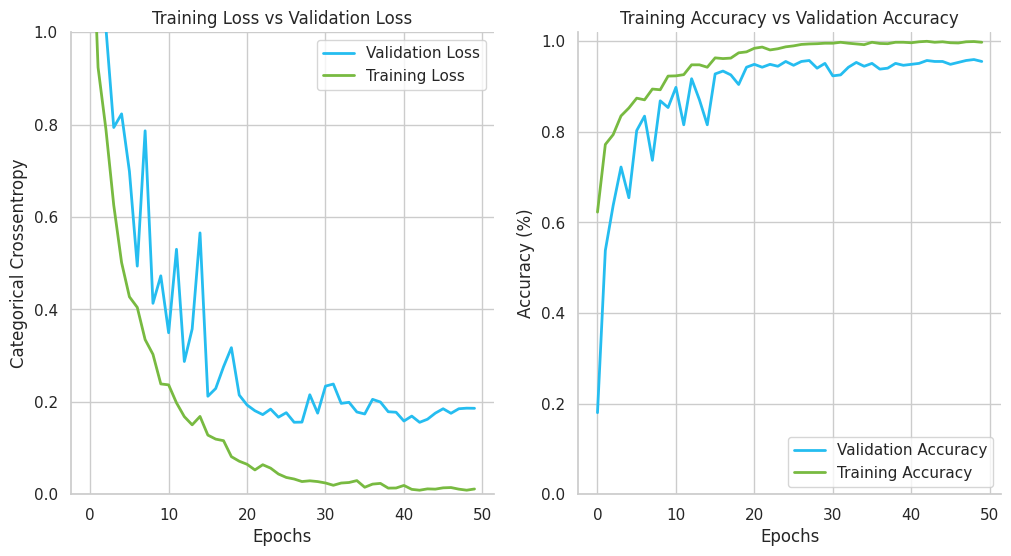

In [ ]:
history_vgg = pd.read_csv("/content/model_results/vgg.log")
plot_history(history_vgg)

## ResNet

### Model Creation

In [ ]:
def ResNet29(input_shape=INPUT_SHAPE):
    """
    Creates a 29 layer residual neural network
    :param input_shape: input shape of the tensors
    :return: 29 model
    """

    # Define the input as a tensor with shape input_shape
    tensor_input = Input(shape=input_shape,
                         batch_size=32,
                         name="Input")

    # Preprocessing layers
    tensor = tf.keras.layers.RandomFlip(mode="horizontal",
                                        input_shape=INPUT_SHAPE,
                                        name="Random_horizontal_flip")(tensor_input)
    tensor = tf.keras.layers.Lambda(function=tf.image.per_image_standardization,
                                    name="Per_image_standardisation")(tensor)
    tensor = PCAColorAugmentationGPU(name="PCA_Colour_Augmentation")(tensor)

    # Convolutional Block
    tensor = ZeroPadding2D(padding=(3, 3),
                           name="ZeroPadding")(tensor)

    tensor = Conv2D(filters=64,
                    kernel_size=(7, 7),
                    strides=(2, 2),
                    kernel_initializer="HeNormal",
                    name="Conv1")(tensor)

    tensor = BatchNormalization(axis=3,
                                name="BatchNorm1")(tensor)

    tensor = ReLU(name="ReLU1")(tensor)

    tensor = MaxPooling2D(pool_size=(3, 3),
                          strides=(2, 2),
                          padding="same",
                          name="MaxPool")(tensor)

    # 1st ResNet Block
    tensor = three_layer_projection_block(tensor,
                                          num_filters=64,
                                          stage=1,
                                          strides=(1, 1))

    tensor = three_layer_identity_block(tensor,
                                        num_filters=64,
                                        stage=2)

    tensor = three_layer_identity_block(tensor,
                                        num_filters=64,
                                        stage=3)

    # 2nd ResNet Block
    tensor = three_layer_projection_block(tensor,
                                          num_filters=128,
                                          stage=4)

    tensor = three_layer_identity_block(tensor,
                                        num_filters=128,
                                        stage=5)

    tensor = three_layer_identity_block(tensor,
                                        num_filters=128,
                                        stage=6)

    tensor = three_layer_identity_block(tensor,
                                        num_filters=128,
                                        stage=7)


    # 3rd ResNet Block
    tensor = three_layer_projection_block(tensor,
                                          num_filters=256,
                                          stage=8)

    tensor = three_layer_identity_block(tensor,
                                        num_filters=256,
                                        stage=9)



    # Global Average Pooling
    tensor = GlobalAveragePooling2D(name="GlobalAvgPooling")(tensor)

    # Output layer
    tensor = Dense(units=5,
                   activation="softmax",
                   bias_initializer=output_bias,
                   name="Output")(tensor)

    # Create model
    model = Model(inputs=tensor_input,
                  outputs=tensor,
                  name="ResNet29")

    return model

In [ ]:
resnet = ResNet29(input_shape=INPUT_SHAPE)

In [ ]:
resnet.summary()

Model: "ResNet29"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(32, 224, 224, 3)]          0         []                            
                                                                                                  
 Random_horizontal_flip (Ra  (32, 224, 224, 3)            0         ['Input[0][0]']               
 ndomFlip)                                                                                        
                                                                                                  
 Per_image_standardisation   (32, 224, 224, 3)            0         ['Random_horizontal_flip[0][0]
 (Lambda)                                                           ']                            
                                                                                           

### Model Compiling

In [ ]:
resnet.compile(loss=SparseCategoricalCrossentropy(),
               optimizer=Adam(),
               metrics=["accuracy"])

### Model Training


#### Callbacks

In [ ]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
resnet_csv_logger = CSVLogger("/content/model_results/resnet.log")

#### Training

In [ ]:
resnet_history = resnet.fit(train_ds,
                            epochs=50,
                            steps_per_epoch=len(train_ds),
                            validation_data=val_ds,
                            validation_steps=len(val_ds),
                            class_weight=class_weights,
                            callbacks=[lr_scheduler, resnet_csv_logger])

Epoch 1/50
59/59 [==============================] - 35s 223ms/step - loss: 0.9408 - accuracy: 0.6695 - val_loss: 1857.6193 - val_accuracy: 0.1483 - lr: 0.0010
Epoch 2/50
59/59 [==============================] - 16s 237ms/step - loss: 0.6472 - accuracy: 0.7643 - val_loss: 44.8617 - val_accuracy: 0.1589 - lr: 0.0010
Epoch 3/50
59/59 [==============================] - 16s 240ms/step - loss: 0.5323 - accuracy: 0.8067 - val_loss: 3.7808 - val_accuracy: 0.5466 - lr: 0.0010
Epoch 4/50
59/59 [==============================] - 16s 239ms/step - loss: 0.4389 - accuracy: 0.8453 - val_loss: 0.6439 - val_accuracy: 0.7564 - lr: 0.0010
Epoch 5/50
59/59 [==============================] - 16s 236ms/step - loss: 0.4047 - accuracy: 0.8316 - val_loss: 0.9845 - val_accuracy: 0.6886 - lr: 0.0010
Epoch 6/50
59/59 [==============================] - 15s 235ms/step - loss: 0.3558 - accuracy: 0.8660 - val_loss: 0.9148 - val_accuracy: 0.7712 - lr: 0.0010
Epoch 7/50
59/59 [==============================] - 15s 235m

### Visualisations

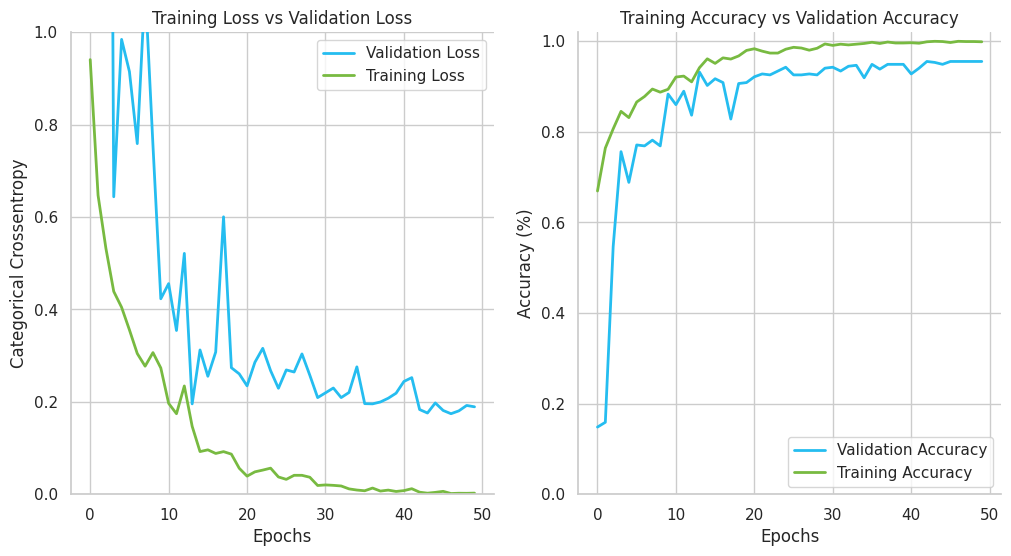

In [ ]:
history_resnet = pd.read_csv("/content/model_results/resnet.log")
plot_history(history_resnet)

## MobileNet

### Model Creation

In [ ]:
def mobilenet(input_shape=INPUT_SHAPE):
    """
    Creates a 35 layer mobilenet neural network
    :param input_shape: input shape of the tensors
    :return: ResNet35 model
    """

    # Define the input as a tensor with shape input_shape
    tensor_input = Input(shape=input_shape,
                         batch_size=32,
                         name="Input")

    # Preprocessing layers
    tensor = tf.keras.layers.RandomFlip(mode="horizontal",
                                        input_shape=INPUT_SHAPE,
                                        name="Random_horizontal_flip")(tensor_input)
    tensor = tf.keras.layers.Lambda(function=tf.image.per_image_standardization,
                                    name="Per_image_standardisation")(tensor)
    tensor = PCAColorAugmentationGPU(name="PCA_Colour_Augmentation")(tensor)

    # Convolutional Block
    tensor = Conv2D(filters=32,
                    kernel_size=(3, 3),
                    strides=(2, 2),
                    padding="same",
                    kernel_initializer="HeNormal",
                    name="Conv1")(tensor)

    tensor = BatchNormalization(axis=3,
                                name="BatchNorm1")(tensor)

    tensor = Activation(activation="relu",
                        name="ReLU1")(tensor)


    # 1st Bottleneck Sequence
    tensor = bottleneck_block(tensor,
                              num_filters=16,
                              stage=1)

    # 2nd Bottleneck Sequence
    tensor = bottleneck_block(tensor,
                              num_filters=24,
                              strides=(2, 2),
                              stage=2)

    tensor = bottleneck_block(tensor,
                              num_filters=24,
                              stage=3)

    # 3rd Bottleneck Sequence
    tensor = bottleneck_block(tensor,
                              num_filters=32,
                              strides=(2, 2),
                              stage=4)

    tensor = bottleneck_block(tensor,
                              num_filters=32,
                              stage=5)

    # 4th Bottleneck Sequence
    tensor = bottleneck_block(tensor,
                              num_filters=64,
                              strides=(2, 2),
                              stage=6)

    tensor = bottleneck_block(tensor,
                              num_filters=64,
                              stage=7)

    tensor = bottleneck_block(tensor,
                              num_filters=64,
                              stage=8)

    tensor = bottleneck_block(tensor,
                              num_filters=64,
                              stage=9)

    # 5th Bottleneck Sequence
    tensor = bottleneck_block(tensor,
                              num_filters=96,
                              stage=10)

    tensor = bottleneck_block(tensor,
                              num_filters=96,
                              stage=11)

    tensor = bottleneck_block(tensor,
                              num_filters=96,
                              stage=12)

    # Convolutional Block
    tensor = Conv2D(filters=160,
                    kernel_size=(1, 1),
                    strides=(1, 1),
                    padding="valid",
                    kernel_initializer="HeNormal",
                    name="Conv2")(tensor)

    tensor = BatchNormalization(axis=3,
                                name="BatchNorm2")(tensor)

    tensor = Activation(activation="relu",
                        name="ReLU2")(tensor)

    # Global Average Pooling
    tensor = GlobalAveragePooling2D(name="GlobalAvgPooling")(tensor)

    # Output layer
    tensor = Dense(units=5,
                   activation="softmax",
                   bias_initializer=output_bias,
                   name="Output")(tensor)


    # Create model
    model = Model(inputs=tensor_input,
                  outputs=tensor,
                  name="mobilenet_2")

    return model

In [ ]:
mnet = mobilenet(input_shape=INPUT_SHAPE)

In [ ]:
mnet.summary()

Model: "mobilenet_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(32, 224, 224, 3)]          0         []                            
                                                                                                  
 Random_horizontal_flip (Ra  (32, 224, 224, 3)            0         ['Input[0][0]']               
 ndomFlip)                                                                                        
                                                                                                  
 Per_image_standardisation   (32, 224, 224, 3)            0         ['Random_horizontal_flip[0][0]
 (Lambda)                                                           ']                            
                                                                                        

### Model Compiling

In [ ]:
mnet.compile(loss=SparseCategoricalCrossentropy(),
             optimizer=Adam(),
             metrics=["accuracy"])

### Model Training


#### Callbacks

In [ ]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
mnet_csv_logger = CSVLogger("/content/model_results/mobilenet.log")

#### Training

In [ ]:
mobilenet_history = mnet.fit(train_ds,
                             epochs=50,
                             steps_per_epoch=len(train_ds),
                             validation_data=val_ds,
                             validation_steps=len(val_ds),
                             class_weight=class_weights,
                             callbacks=[lr_scheduler, mnet_csv_logger])

Epoch 1/50
59/59 [==============================] - 39s 218ms/step - loss: 0.9501 - accuracy: 0.6224 - val_loss: 1.4677 - val_accuracy: 0.4831 - lr: 0.0010
Epoch 2/50
59/59 [==============================] - 15s 231ms/step - loss: 0.5929 - accuracy: 0.7791 - val_loss: 1.5491 - val_accuracy: 0.4831 - lr: 0.0010
Epoch 3/50
59/59 [==============================] - 15s 233ms/step - loss: 0.4404 - accuracy: 0.8374 - val_loss: 1.7257 - val_accuracy: 0.4831 - lr: 0.0010
Epoch 4/50
59/59 [==============================] - 15s 232ms/step - loss: 0.3623 - accuracy: 0.8612 - val_loss: 1.8691 - val_accuracy: 0.4831 - lr: 0.0010
Epoch 5/50
59/59 [==============================] - 16s 234ms/step - loss: 0.3184 - accuracy: 0.8745 - val_loss: 1.8954 - val_accuracy: 0.4831 - lr: 0.0010
Epoch 6/50
59/59 [==============================] - 15s 230ms/step - loss: 0.2975 - accuracy: 0.8845 - val_loss: 1.6327 - val_accuracy: 0.4831 - lr: 0.0010
Epoch 7/50
59/59 [==============================] - 15s 231ms/st

### Visualisations

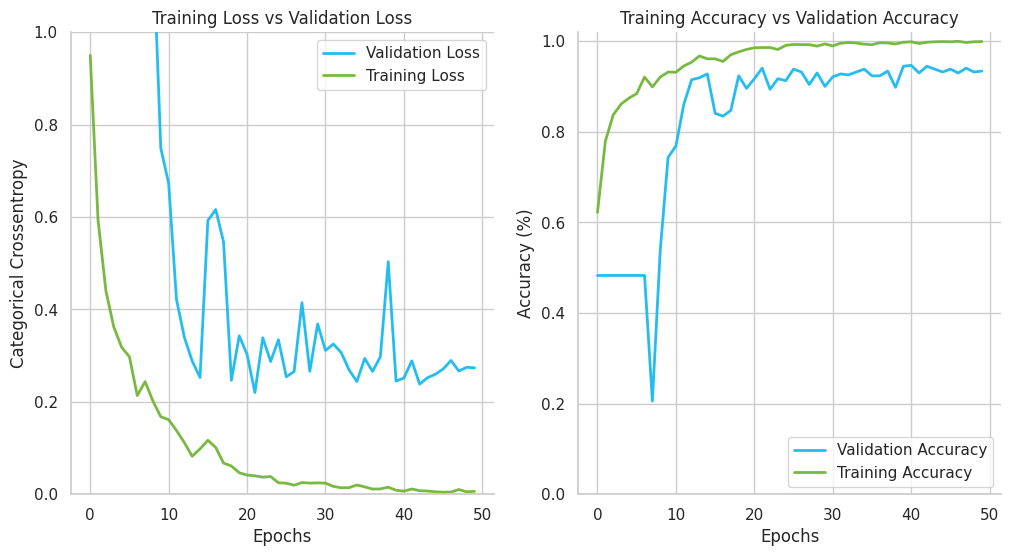

In [ ]:
history_mobilenet = pd.read_csv("/content/model_results/mobilenet.log")
plot_history(history_mobilenet)

# Transfer Learning

## Models

### VGG 19

In [ ]:
vgg_19 = Sequential([
    Lambda(vgg_preproccessing,
           input_shape=INPUT_SHAPE),

    VGG19(include_top=False,
          weights="imagenet",
          pooling="max",
          input_shape=INPUT_SHAPE),

    Dense(units=5,
          activation="softmax")
])

vgg_19.layers[1].trainable = False

vgg_19.summary()

80134624/80134624 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense (Dense)               (None, 5)                 2565      
                                                                 
Total params: 20026949 (76.40 MB)
Trainable params: 2565 (10.02 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [ ]:
vgg_19.compile(optimizer=Adam(),
               loss=SparseCategoricalCrossentropy(),
               metrics=["accuracy"])

vgg_19_csv_logger = CSVLogger("/content/transfer/vgg_19.log")

hist_vgg_19 = vgg_19.fit(train_ds,
                         epochs=25,
                         steps_per_epoch=len(train_ds),
                         validation_data=val_ds,
                         validation_steps=len(val_ds),
                         callbacks=[vgg_19_csv_logger])

Epoch 1/25
59/59 [==============================] - 20s 257ms/step - loss: 14.7184 - accuracy: 0.4211 - val_loss: 6.7976 - val_accuracy: 0.5763
Epoch 2/25
59/59 [==============================] - 15s 227ms/step - loss: 4.6284 - accuracy: 0.6621 - val_loss: 3.7949 - val_accuracy: 0.7225
Epoch 3/25
59/59 [==============================] - 15s 226ms/step - loss: 2.7140 - accuracy: 0.7680 - val_loss: 2.9234 - val_accuracy: 0.7648
Epoch 4/25
59/59 [==============================] - 15s 224ms/step - loss: 1.8305 - accuracy: 0.8189 - val_loss: 2.5542 - val_accuracy: 0.8008
Epoch 5/25
59/59 [==============================] - 15s 224ms/step - loss: 1.2888 - accuracy: 0.8575 - val_loss: 2.6745 - val_accuracy: 0.7839
Epoch 6/25
59/59 [==============================] - 15s 225ms/step - loss: 0.9967 - accuracy: 0.8808 - val_loss: 2.1050 - val_accuracy: 0.8136
Epoch 7/25
59/59 [==============================] - 15s 228ms/step - loss: 0.7228 - accuracy: 0.9078 - val_loss: 1.7945 - val_accuracy: 0.828

### ResNet50 V2

In [ ]:
res50_v2 = Sequential([
    Lambda(resnet_v2_preproccessing,
           input_shape=INPUT_SHAPE),

    ResNet50V2(include_top=False,
               pooling="avg",
               weights="imagenet",
               input_shape=INPUT_SHAPE),

    Dense(units=5,
          activation="softmax")
])

res50_v2.layers[1].trainable = False

res50_v2.summary()

94668760/94668760 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 23575045 (89.93 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
res50_v2.compile(optimizer=Adam(),
                           loss=SparseCategoricalCrossentropy(),
                           metrics=["accuracy"])

res50_v2_csv_logger = CSVLogger("/content/transfer/res50_v2.log")

hist_res50_v2 = res50_v2.fit(train_ds,
                             epochs=25,
                             steps_per_epoch=len(train_ds),
                             validation_data=val_ds,
                             validation_steps=len(val_ds),
                             callbacks=[res50_v2_csv_logger])

Epoch 1/25
59/59 [==============================] - 20s 242ms/step - loss: 0.7613 - accuracy: 0.7251 - val_loss: 0.4267 - val_accuracy: 0.8644
Epoch 2/25
59/59 [==============================] - 15s 222ms/step - loss: 0.3167 - accuracy: 0.8946 - val_loss: 0.3338 - val_accuracy: 0.8941
Epoch 3/25
59/59 [==============================] - 15s 222ms/step - loss: 0.2257 - accuracy: 0.9370 - val_loss: 0.3115 - val_accuracy: 0.8983
Epoch 4/25
59/59 [==============================] - 15s 223ms/step - loss: 0.1759 - accuracy: 0.9587 - val_loss: 0.2674 - val_accuracy: 0.9153
Epoch 5/25
59/59 [==============================] - 15s 218ms/step - loss: 0.1429 - accuracy: 0.9703 - val_loss: 0.2635 - val_accuracy: 0.9195
Epoch 6/25
59/59 [==============================] - 15s 223ms/step - loss: 0.1219 - accuracy: 0.9751 - val_loss: 0.2488 - val_accuracy: 0.9195
Epoch 7/25
59/59 [==============================] - 14s 219ms/step - loss: 0.1040 - accuracy: 0.9820 - val_loss: 0.2399 - val_accuracy: 0.9237

### MobileNet V2

In [ ]:
mobilenet_v2 = Sequential([
    Lambda(mobilenet_preprocessing,
           input_shape=INPUT_SHAPE),

    MobileNetV2(include_top=False,
                pooling="avg",
                weights="imagenet",
                input_shape=INPUT_SHAPE),

    Dense(units=5,
          activation="softmax")
])

mobilenet_v2.layers[1].trainable = False

mobilenet_v2.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dense_2 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
mobilenet_v2.compile(optimizer=Adam(),
                     loss=SparseCategoricalCrossentropy(),
                     metrics=["accuracy"])

mobilenet_v2_csv_logger = CSVLogger("/content/transfer/mobilenet_v2.log")

hist_mobilenet_v2 = mobilenet_v2.fit(train_ds,
                                     epochs=25,
                                     steps_per_epoch=len(train_ds),
                                     validation_data=val_ds,
                                     validation_steps=len(val_ds),
                                     callbacks=[mobilenet_v2_csv_logger])

Epoch 1/25
59/59 [==============================] - 18s 230ms/step - loss: 0.7765 - accuracy: 0.7177 - val_loss: 0.4514 - val_accuracy: 0.8644
Epoch 2/25
59/59 [==============================] - 15s 221ms/step - loss: 0.3352 - accuracy: 0.9089 - val_loss: 0.3418 - val_accuracy: 0.8962
Epoch 3/25
59/59 [==============================] - 15s 220ms/step - loss: 0.2567 - accuracy: 0.9296 - val_loss: 0.3082 - val_accuracy: 0.9047
Epoch 4/25
59/59 [==============================] - 14s 220ms/step - loss: 0.2052 - accuracy: 0.9481 - val_loss: 0.2732 - val_accuracy: 0.9174
Epoch 5/25
59/59 [==============================] - 14s 220ms/step - loss: 0.1686 - accuracy: 0.9613 - val_loss: 0.2577 - val_accuracy: 0.9131
Epoch 6/25
59/59 [==============================] - 15s 220ms/step - loss: 0.1434 - accuracy: 0.9661 - val_loss: 0.2467 - val_accuracy: 0.9195
Epoch 7/25
59/59 [==============================] - 15s 217ms/step - loss: 0.1266 - accuracy: 0.9682 - val_loss: 0.2376 - val_accuracy: 0.9174

### EfficientnetB3 V2

In [ ]:
efficientnet_b3_v2 = Sequential([
    Lambda(efficientnet_preproccessing,
           input_shape=INPUT_SHAPE),

    EfficientNetV2B3(include_top=False,
                     weights="imagenet",
                     pooling="avg",
                     input_shape=INPUT_SHAPE),

    Dense(units=5,
          activation="softmax")
])

efficientnet_b3_v2.layers[1].trainable = False

efficientnet_b3_v2.summary()

52606240/52606240 [==============================] - 2s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_3 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b3 (Functio  (None, 1536)              12930622  
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 5)                 7685      
                                                                 
Total params: 12938307 (49.36 MB)
Trainable params: 7685 (30.02 KB)
Non-trainable params: 12930622 (49.33 MB)
_________________________________________________________________


In [ ]:
efficientnet_b3_v2.compile(optimizer=Adam(),
                           loss=SparseCategoricalCrossentropy(),
                           metrics=["accuracy"])

efficientnet_b3_v2_csv_logger = CSVLogger("/content/transfer/efficientnet_b3_v2.log")

hist_efficientnet_b3_v2 = efficientnet_b3_v2.fit(train_ds,
                                                 epochs=25,
                                                 steps_per_epoch=len(train_ds),
                                                 validation_data=val_ds,
                                                 validation_steps=len(val_ds),
                                                 callbacks=[efficientnet_b3_v2_csv_logger])

Epoch 1/25
59/59 [==============================] - 30s 286ms/step - loss: 0.8340 - accuracy: 0.7188 - val_loss: 0.4691 - val_accuracy: 0.8559
Epoch 2/25
59/59 [==============================] - 15s 222ms/step - loss: 0.4090 - accuracy: 0.8856 - val_loss: 0.3304 - val_accuracy: 0.9174
Epoch 3/25
59/59 [==============================] - 15s 224ms/step - loss: 0.2981 - accuracy: 0.9232 - val_loss: 0.2727 - val_accuracy: 0.9364
Epoch 4/25
59/59 [==============================] - 15s 224ms/step - loss: 0.2391 - accuracy: 0.9401 - val_loss: 0.2386 - val_accuracy: 0.9428
Epoch 5/25
59/59 [==============================] - 15s 223ms/step - loss: 0.2097 - accuracy: 0.9513 - val_loss: 0.2165 - val_accuracy: 0.9449
Epoch 6/25
59/59 [==============================] - 15s 222ms/step - loss: 0.1851 - accuracy: 0.9560 - val_loss: 0.2034 - val_accuracy: 0.9449
Epoch 7/25
59/59 [==============================] - 15s 221ms/step - loss: 0.1735 - accuracy: 0.9513 - val_loss: 0.1922 - val_accuracy: 0.9513

## Visualisations

### Loading logs

In [ ]:
eff_b3_v2 = pd.read_csv("/content/transfer/efficientnet_b3_v2.log")
mobile_v2 = pd.read_csv("/content/transfer/mobilenet_v2.log")
res50_v2 = pd.read_csv("/content/transfer/res50_v2.log")
vgg19 = pd.read_csv("/content/transfer/vgg_19.log")

models = [vgg19, res50_v2, mobile_v2,eff_b3_v2]
names = ["VGG 19", "ResNet50 V2", "MobileNet V2", "Efficientnet B3 V2"]
colours = ["#048a7c", "#25bdf0", "#78ba41", "#08aca4"]

### Validation Losses

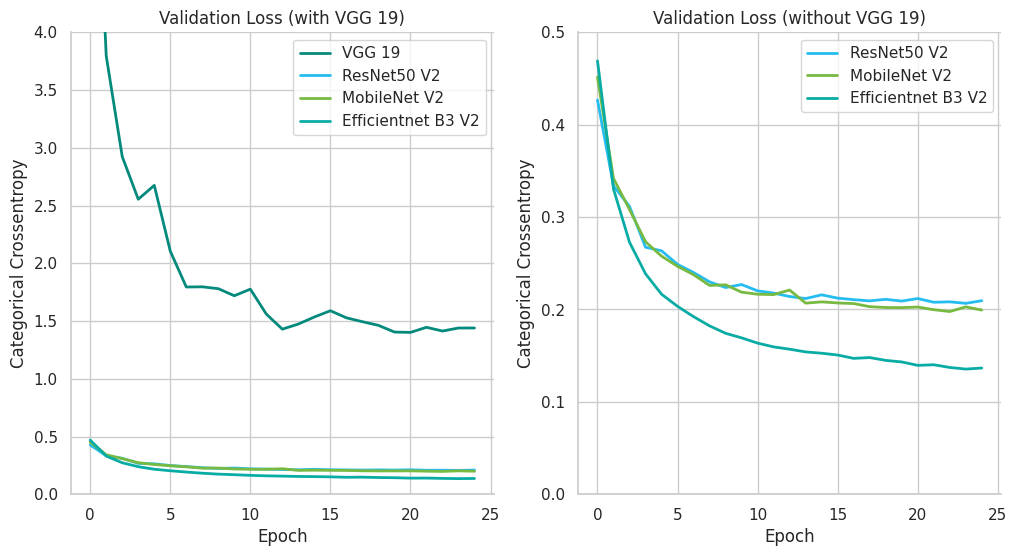

In [ ]:
fig, ax = plt.subplots(figsize=(12,6), nrows=1, ncols=2)

for model, name, colour in zip(models, names, colours):

  sns.lineplot(data=model,
               x="epoch",
               y="val_loss",
               ax=ax[0],
               label=name,
               linewidth=2,
               color=colour)

  if name != "VGG 19":

    sns.lineplot(data=model,
               x="epoch",
               y="val_loss",
               ax=ax[1],
               label=name,
               linewidth=2,
               color=colour)

ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Categorical Crossentropy")
ax[0].set_title("Validation Loss (with VGG 19)")
ax[0].set_ylim((0, 4))
ax[0].legend()

ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Categorical Crossentropy")
ax[1].set_title("Validation Loss (without VGG 19)")
ax[1].set_ylim((0, 0.5))
ax[1].legend()

plt.show()

### Validation Accuracies

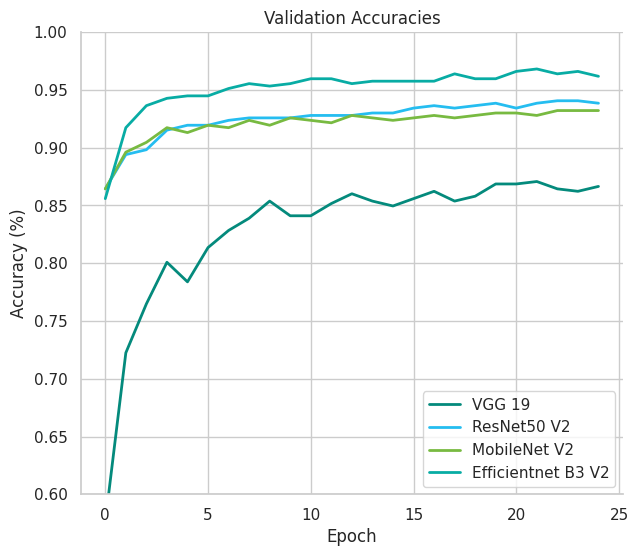

In [ ]:
fig, ax = plt.subplots(figsize=(7,6), nrows=1, ncols=1)

for model, name, colour in zip(models, names, colours):

  sns.lineplot(data=model,
               x="epoch",
               y="val_accuracy",
               ax=ax,
               label=name,
               linewidth=2,
               color=colour)

ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Validation Accuracies")
ax.set_ylim((0.6, 1))
ax.legend()

plt.show()